## Region init

In [1]:
import pandas as pd
import geopandas as gpd

towns = gpd.read_parquet('data/_towns.parquet')
settlements = gpd.read_parquet('data/_okrugs.parquet')
districts = gpd.read_parquet('data/_rayons.parquet')
adj_mx = pd.read_pickle('data/_adj_mx.pickle')

In [2]:
territories = [gpd.read_file(f'data/territories/{terr}.geojson') for terr in ['lodey', 'shlis', 'siver', 'sveto']]
territories = pd.concat(territories).reset_index(drop=True).to_crs(towns.crs)

In [3]:
from townsnet.models.region import Region

region = Region(
  districts=districts, 
  settlements=settlements, 
  towns=towns,
  accessibility_matrix=adj_mx,
  territories=territories
)

In [4]:
region.get_territories_gdf()

,name,geometry
id,,
0,Аэродром Лодейнопольское поселение,"POLYGON ((529877.020 6730827.593, 529893.182 6..."
1,Проект Шлиссельбург,"POLYGON ((387861.999 6644712.938, 388202.551 6..."
2,Аэродром Сиверский,"POLYGON ((329788.882 6583309.434, 330250.950 6..."
3,Проект Светогорское поселение,"POLYGON ((278277.965 6784490.204, 279737.375 6..."


In [5]:
region.get_service_types_df()

,category,infrastructure,name,name_ru,weight,accessibility,demand
0,BASIC,EDUCATION,kindergarten,детский сад,0.20,7,61
1,BASIC,EDUCATION,school,школа,0.20,15,120
2,BASIC,HEALTHCARE,health_center,ФАП / амбулатория,0.20,10,13
3,BASIC,HEALTHCARE,pharmacy,аптека,0.20,15,15
4,BASIC,COMMERCE,convenience,продуктовый магазин,0.20,5,180
5,BASIC,COMMERCE,houseware,хозяйственный магазин,0.20,5,180
6,BASIC,CATERING,cafe,кафе / кофейня,0.15,15,25
7,BASIC,LEISURE,sports_hall,универсальный зал,0.10,15,180
8,BASIC,RECREATION,playground,детская площадка,0.20,4,2
9,BASIC,RECREATION,park,сквер / бульвар / лесопарк,0.20,30,150


## Fill service types data

In [6]:
import osmnx as ox

polygon = region.geometry
gdfs = {}
for service_type in region.service_types:
  try:
    gdf = gpd.read_parquet(f'data/services/{service_type.name}.parquet')
  except:
    gdf = ox.features_from_polygon(polygon, tags=service_type.osm_tags).reset_index().to_crs(region.crs)
    gdf = region.match_services_towns(gdf)
    gdf['capacity'] = 250
    gdf.geometry = gdf.representative_point()
  gdfs[service_type.name] = gdf

In [7]:
for service_type, gdf in gdfs.items():
  region.update_services(service_type, gdf)

In [8]:
region.get_services_gdf()

,town,service_type,geometry,capacity
0,Бор,kindergarten,POINT (545062.236 6592984.549),250
1,Бор,school,POINT (545003.453 6592946.638),250
2,Бор,cafe,POINT (545057.111 6593074.763),250
3,Дмитрово,bus_stop,POINT (556606.517 6570799.269),250
4,Ларьян,school,POINT (543946.962 6596292.051),250
...,...,...,...,...
20885,Апраксин Бор,bus_stop,POINT (399227.549 6560566.367),250
20886,Апраксин Бор,bus_stop,POINT (399216.723 6560632.806),250
20887,Большая Горка,bus_stop,POINT (413170.857 6573826.061),250
20888,Большая Горка,parking,POINT (413177.388 6573887.691),250


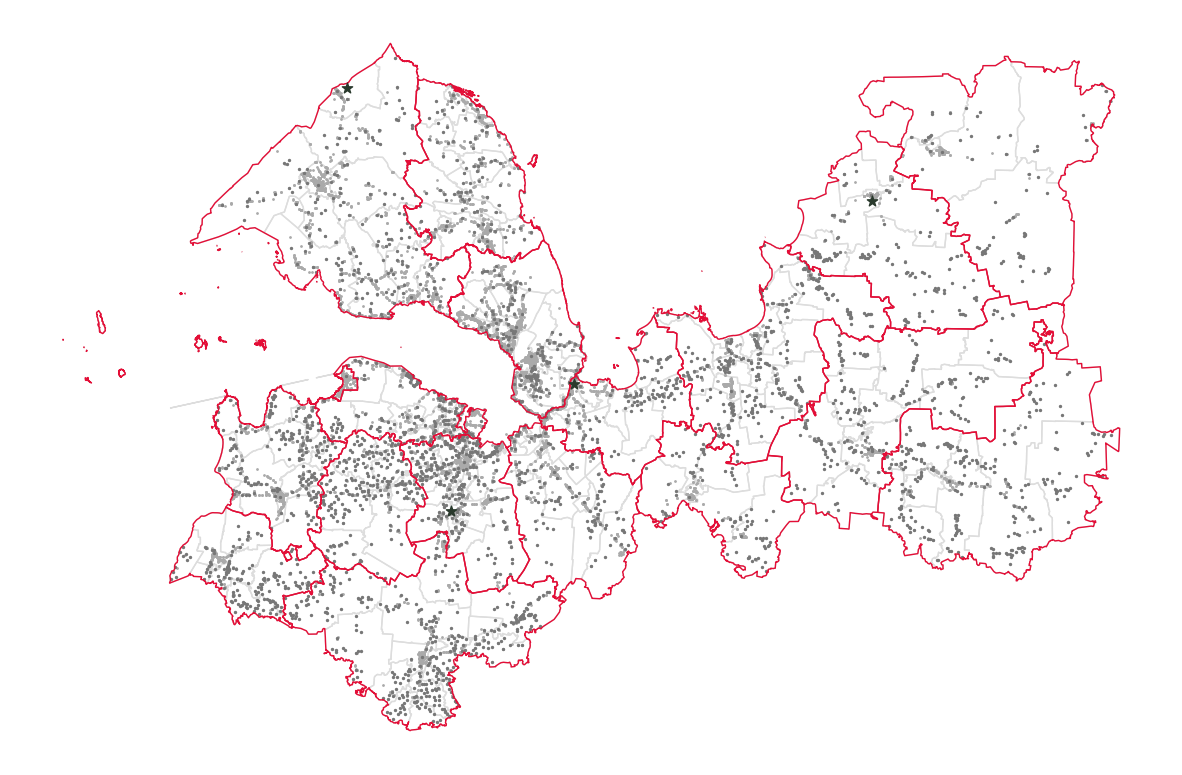

In [9]:
region.plot()

In [10]:
region.to_pickle('data/region.pickle')